In [0]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
from tqdm import trange
import datetime as dt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd 'drive/My Drive/BTP_Code'

/content/drive/My Drive/BTP_Code


In [0]:
ls

 Ayush_gs
'BTP Covid Colab Grid Search+ Lin Param + CVal'
 btpcovid-Copy1.ipynb
 Country_names.npy
 c_values10.npy
 cValues2.npy
 c_values5.npy
 c_values.npy
 cValues.npy
 finc_values10.npy
 finc_values5.npy
 finlinearly_regressed_params10.npy
 finlinearly_regressed_params5.npy
 finmeta10.csv
 finmeta5.csv
 finout10.csv
 finout5.csv
 get_c_values.ipynb
 italy.csv
 linearly_regressed_params10.npy
 linearly_regressed_params5.npy
 linearly_regressed_params.npy
 LRP.npy
 newout10.csv
 newout5.csv
 newout.csv
 out10.csv
 out5.csv
 out.csv
 outer.csv
 out_old.csv
 PredictingCovid
 regression_out_file.ipynb
'Set up file'
 testc_values10.npy
 testc_values5.npy
 testfinout10.csv
 testfinout5.csv
 testlrp10.npy
 testlrp5.npy
 testmeta10.csv
 testmeta3.csv
 testmeta5.csv
 TopCountriesData.npy
 TopCountriesDataReverseSorted.npy
 Untitled.ipynb
 us_ny.csv


In [0]:
data_country = np.load('TopCountriesDataReverseSorted.npy')
c_values = np.load('cValues2.npy')
data = np.load('LRP2.npy')
country_names = np.load('Country_names.npy')

train_x = data[:,:2]
y_w1 = data[:,2]
y_w2 = data[:,3]
y_w3 = data[:,4]
y_wG = data[:,5]

trdays=7
tedays=3

In [0]:
def meta_predictor(x_train,x_test,c,w_2):
    output=0
    for i in range(x_train.shape[0]):
        #print(c[i],meta_kernel_formula(x_train[i],x_test,w_1,w_2),c[i]*meta_kernel_formula(x_train[i],x_test,w_1,w_2))
        output+=c[i]*meta_kernel_formula(x_train[i],x_test,w_2)
    return output

def meta_kernel_formula(x_i,x_j,w_2):
    temp = np.square(np.linalg.norm(x_i-x_j))
    return np.exp(-w_2*temp)

def kernel_formula(x_i,x_j,w_1,w_2,w_3):
    return np.power(x_i*x_j,w_1)+w_2*np.exp(-w_3*np.square(x_i-x_j))

def kernel_matrix_generator(x,w_1,w_2,w_3):
    kernel_matrix = np.zeros(shape=(x.shape[0],x.shape[0]))
    i=0
    for x_i in x:
        j=0
        for x_j in x:
            kernel_matrix[i,j] = kernel_formula(x_i,x_j,w_1,w_2,w_3)
            j+=1
        i+=1
    return kernel_matrix

def solver(x,y,gamma,w_1,w_2,w_3):
    kernel_matrix = kernel_matrix_generator(x,w_1,w_2,w_3)
    A = gamma*(kernel_matrix.shape[0])*np.identity(kernel_matrix.shape[0])
    A = np.add(A,kernel_matrix)
    B=y
    c = np.linalg.solve(A,B)
    return c

def predictor(x_train,x_test,y_train,gamma,w_1,w_2,w_3):
    c = solver(x_train,y_train,gamma,w_1,w_2,w_3)
    output = np.zeros(shape=(x_test.shape[0]))
    for j in range(x_test.shape[0]):
        for i in range(x_train.shape[0]):
            output[j]+=c[i]*kernel_formula(x_train[i],x_test[j],w_1,w_2,w_3)
    return output

def prediction_nth_day(sample):
    counts = sample
    start = dt.datetime.strptime("1 Jan 20", "%d %b %y")
    daterange = pd.date_range(start, periods=trdays)
    table = {"count": counts, "date": daterange}
    data = pd.DataFrame(table)
    data.set_index("date", inplace=True)
    order = (1, 2, 0)
    model = ARIMA(data, order, freq='D')
    model = model.fit()
    temp = model.predict(2, tedays+trdays-1, typ = 'levels')
    return temp[-1]

In [0]:
def PlotTest(country_id,country_day,p=0,i=0,j=0,k=0,l=0):
  xtrain=data_country[country_id,country_day:country_day+trdays] 
  #print(xtest)
  reg = LinearRegression().fit(np.arange(1,trdays+1).reshape(-1,1),xtrain.reshape(-1,1))
  inter = reg.intercept_[0]
  temp = reg.predict(np.arange(1,trdays+1).reshape(-1,1))
  slope = (temp[1,0]-temp[0,0])
  #print(slope,inter)
  # print(i,j,k,l)
  if(i==0):
    w1=meta_predictor(train_x,[slope,inter],c_values[0],20)
  else:
    w1=i
  if(j==0):
    w2=meta_predictor(train_x,[slope,inter],c_values[1],20)
  else:
    w2=j
  if(k==0):
    w3=meta_predictor(train_x,[slope,inter],c_values[2],20)
  else:
    w3=k
  if(l==0):
    gam=meta_predictor(train_x,[slope,inter],c_values[3],20) 
  else:
    gam=l
  #print(w1,w2,w3)
  if(p!=0):
    print('Params predicted: ',w1,w2,w3,gam) #Use these W_i

  if(w1<0.01):
    w1=0.01
  elif (w1>3):
    w1=3
  if(w2<1):
    w2=1
  elif(w2>300):
    w2=300
  if(w3<0.00001):
    w3=0.00001
  elif(w3>0.02):
    w3=0.02
  if(gam<0.0001):
    gam=0.0001
  elif(gam>0.01):
    gam=0.01
  if(p!=0):
    print('Params predicted: ',w1,w2,w3,gam) #Use these W_i

  output = predictor(np.arange(1,trdays+1),np.arange(1,trdays+tedays+1),xtrain,gam,w1,w2,w3)
  # print('Original : ',data_country[country_id,country_day:country_day+14])
  # print('Predicted: ',output)
  #return output[trdays+tedays-1]
  return output
  '''
  plt.plot(np.arange(1,15),data_country[country_id,country_day:country_day+14],label='original')
  plt.plot(np.arange(1,15),output,label='predicted')
  plt.legend()
  plt.xlabel('No. of days')
  plt.ylabel('No. of deceased')
  # if(output[13]>data_country[country_id,country_day:country_day+14][13]):
  #   plt.ylim(0,output[13]+1 )
  # else:
  #   plt.ylim(0,data_country[country_id,country_day:country_day+14][13]+1)

  plt.show()
  '''
  

Params predicted:  0.7464364654788266 -1.2332315514472283 0.02028553125341032 0.00862888678451732
Params predicted:  0.7464364654788266 1 0.02 0.00862888678451732
CID: 2  CD: 44  -------------------Exp Err: 1930.0942997333257 Log Err: 0.29595201757977363


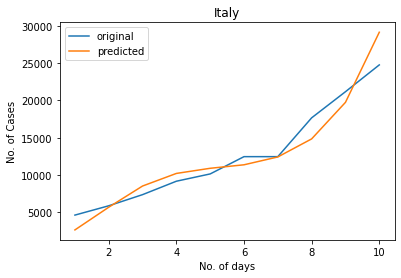

In [0]:
#simple plotting of prediction
i = 2
j = 44
output= PlotTest(i,j,1,0,0,0,0)
err= MSE(2**data_country[i,j:j+trdays+tedays]-1,2**output-1)
print('CID:',i,' CD:',j,' -------------------Exp Err:',err**0.5,'Log Err:',MSE(data_country[i,j:j+trdays+tedays],output)**0.5)
plt.plot(np.arange(1,trdays+tedays+1),2**data_country[i,j:j+trdays+tedays],label='original')
plt.plot(np.arange(1,trdays+tedays+1),2**output,label='predicted')
plt.legend()
plt.title(country_names[i,0])
plt.xlabel('No. of days')
plt.ylabel('No. of Cases')
# if(output[13]>data_country[country_id,country_day:country_day+14][13]):
#   plt.ylim(0,output[13]+1 )
# else:
#   plt.ylim(0,data_country[country_id,country_day:country_day+14][13]+1)
plt.show()
#negative values of w2 tried
#took only bigger(positive) values of w2 during grid search

In [0]:
till_day = 90
mapp = np.zeros((data_country.shape[0],till_day))
for i in trange(data_country.shape[0], desc ="loop "):
  for j in range(0,till_day,1):
        mapp[i,j] = PlotTest(i,j)[-1]
        #output = PlotTest(i,j)
        #Why have you declared it this way
        #temp = np.zeros(5)
        #temp = np.zeros(3)
        #temp[0] = i
        #temp[1] = j
        #temp[2] = output
        #mapp.append(temp)


loop : 100%|██████████| 56/56 [00:18<00:00,  3.05it/s]


CID: 0
Error Meta:  32482.018705719307


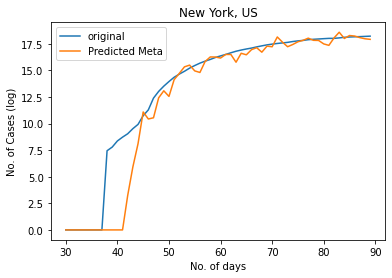

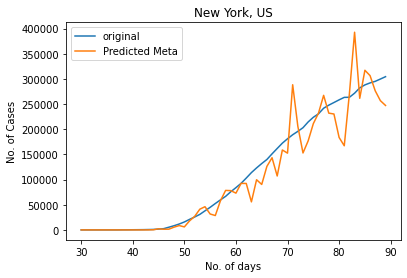

CID: 1
Error Meta:  20213.612343039134


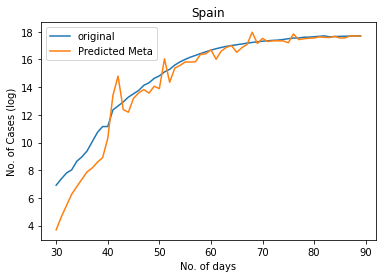

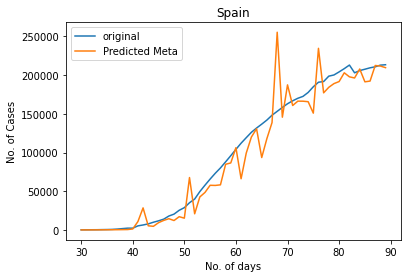

CID: 2
Error Meta:  17486.35170466328


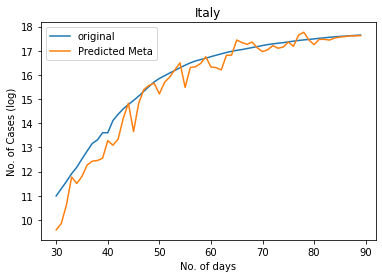

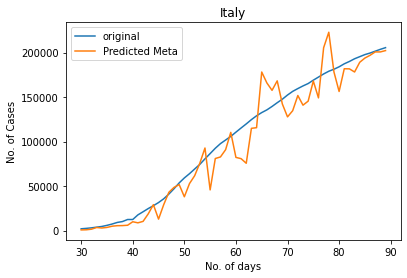

CID: 3
Error Meta:  16229.313664010022


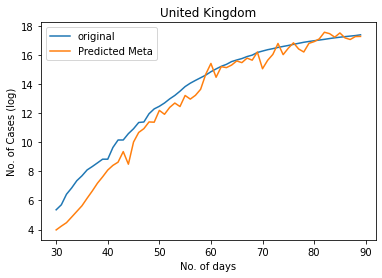

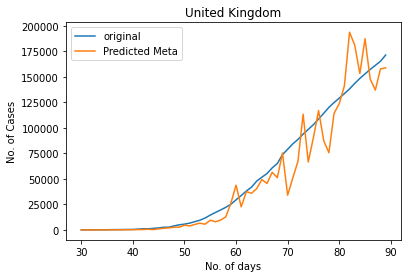

CID: 4
Error Meta:  29911.950562025882


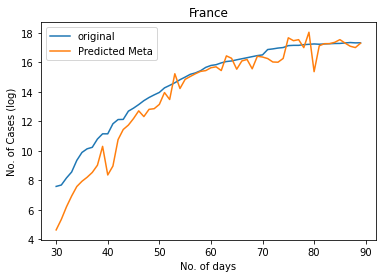

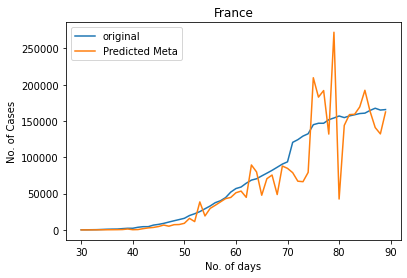

CID: 5
Error Meta:  23122.947731901608


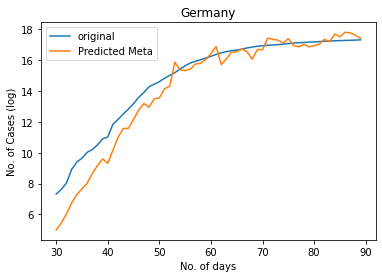

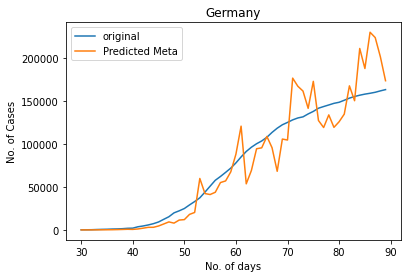

CID: 6
Error Meta:  11685.534633743258


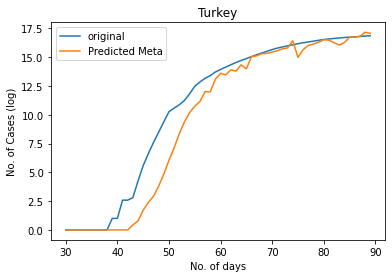

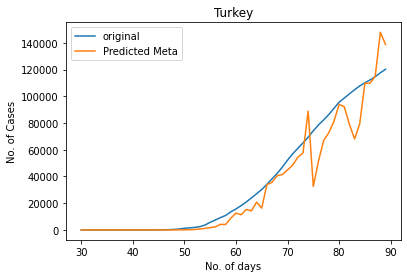

CID: 7
Error Meta:  7850.360526755564


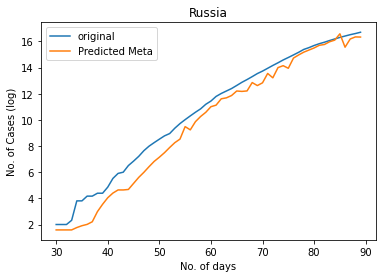

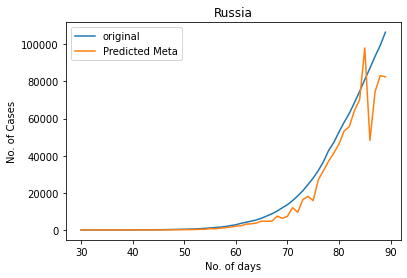

CID: 8
Error Meta:  11616.22519756064


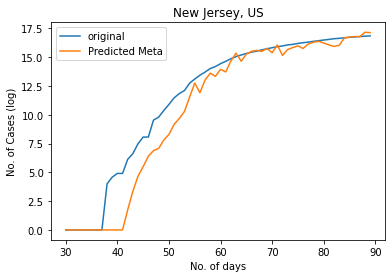

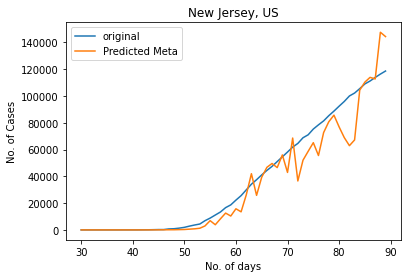

CID: 9
Error Meta:  8094.003193991779


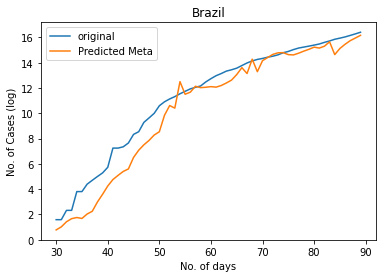

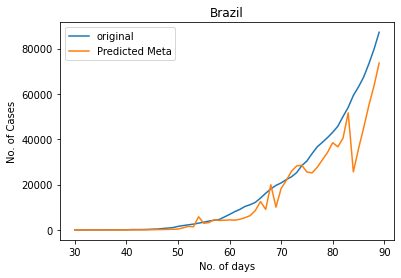

CID: 10
Error Meta:  10439.110664325946


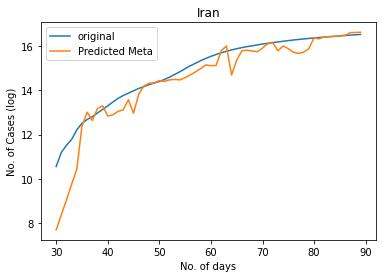

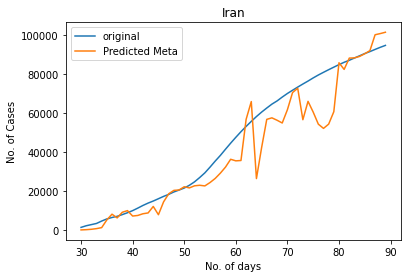

CID: 11
Error Meta:  6345.484008676238


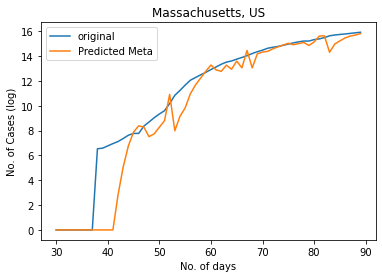

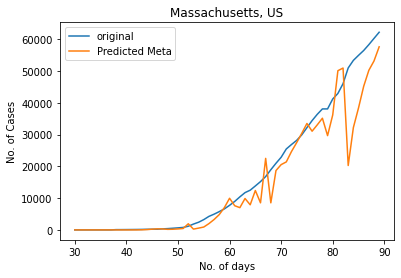

CID: 12
Error Meta:  6391.761612432231


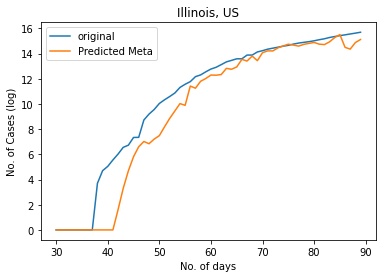

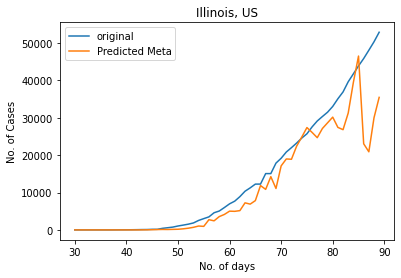

CID: 13
Error Meta:  5576.9044126627905


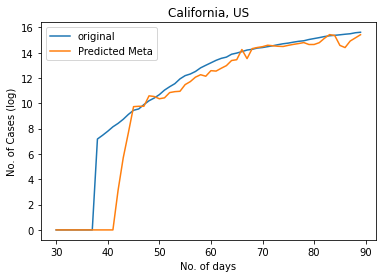

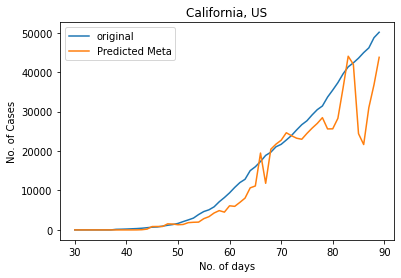

CID: 14
Error Meta:  5162.4381931345915


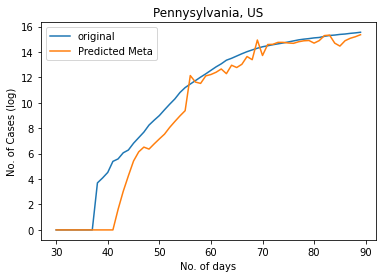

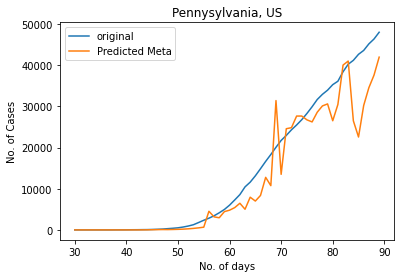

CID: 15
Error Meta:  5702.859617559753


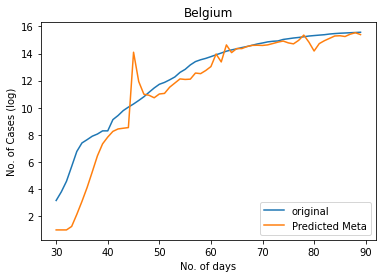

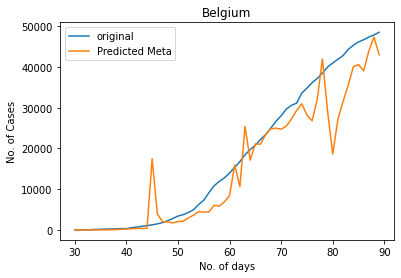

CID: 16
Error Meta:  4871.508379212699


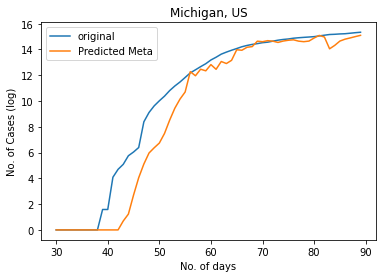

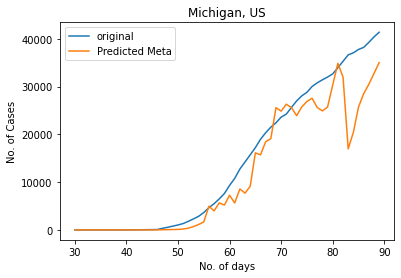

CID: 17
Error Meta:  2411.678887381339


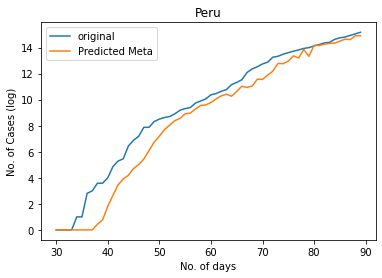

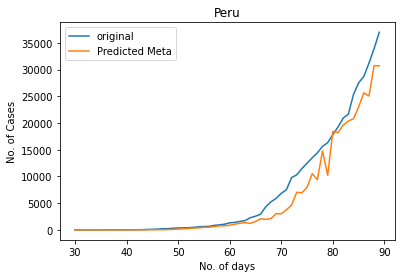

CID: 18
Error Meta:  4633.056083951236


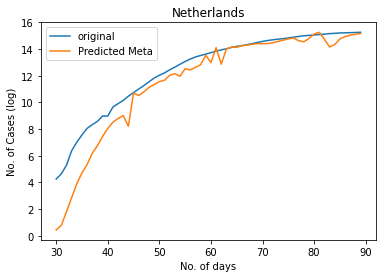

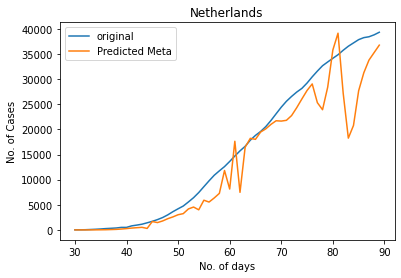

CID: 19
Error Meta:  2117.5273592982485


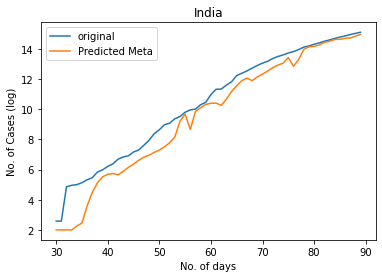

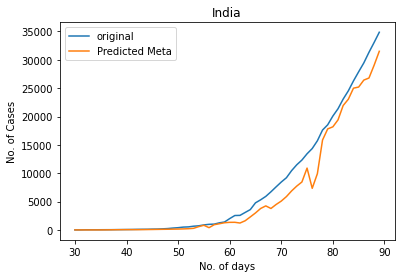

CID: 20
Error Meta:  5691.845723702814


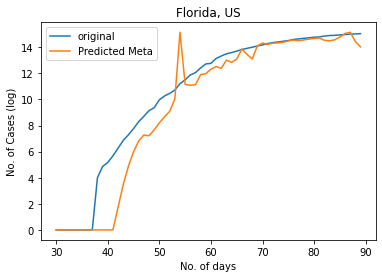

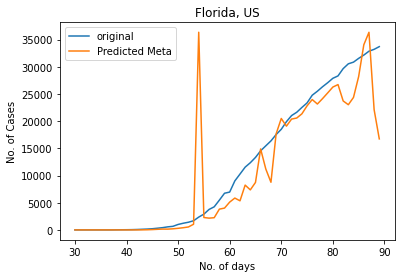

CID: 21
Error Meta:  1922.5090870595693


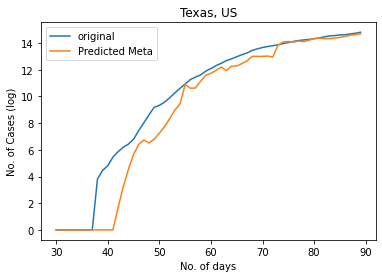

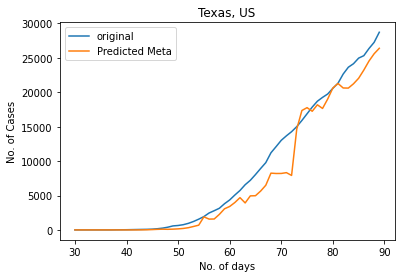

CID: 22
Error Meta:  5073.741601515966


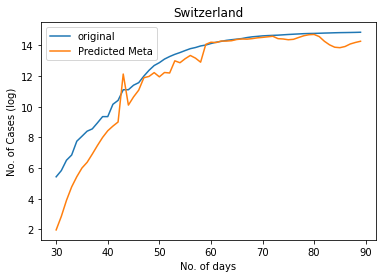

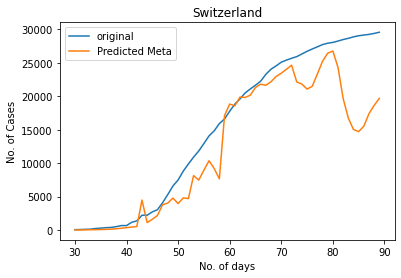

CID: 23
Error Meta:  1843.6143786094317


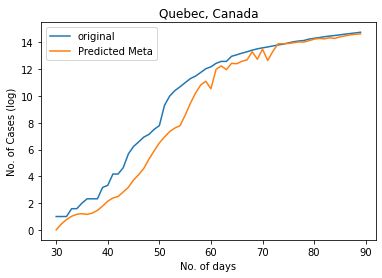

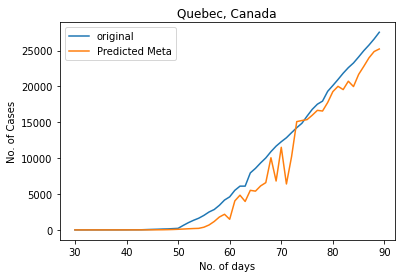

CID: 24
Error Meta:  1820.0939506989077


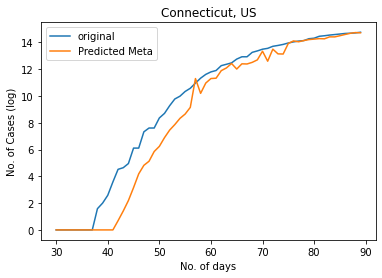

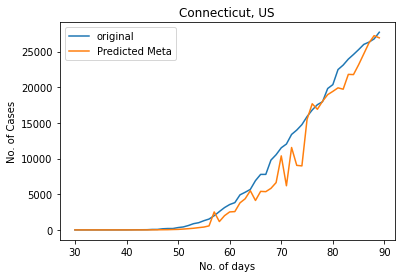

CID: 25
Error Meta:  3103.911988830702


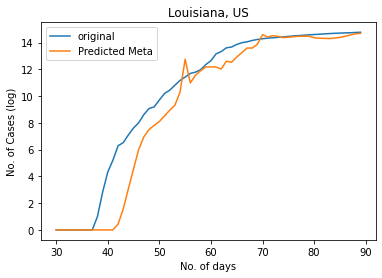

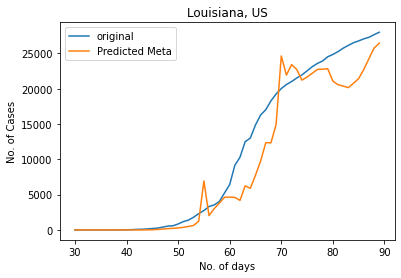

CID: 26
Error Meta:  1907.2422358751007


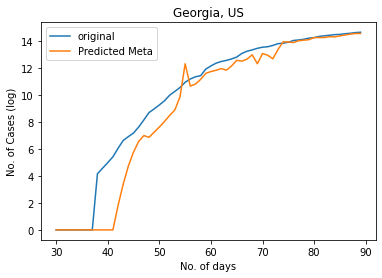

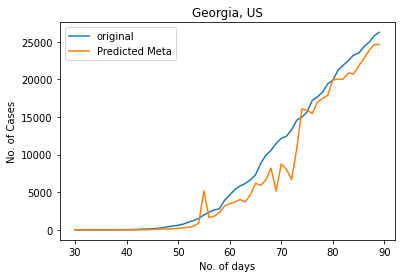

CID: 27
Error Meta:  4417.30609325359


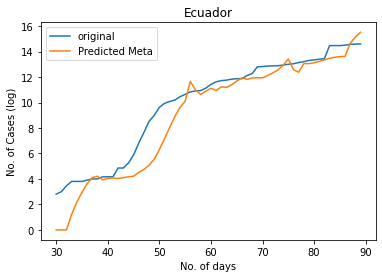

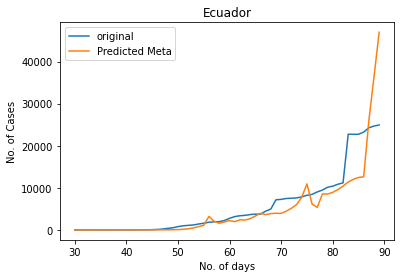

CID: 28
Error Meta:  2093.1348142053075


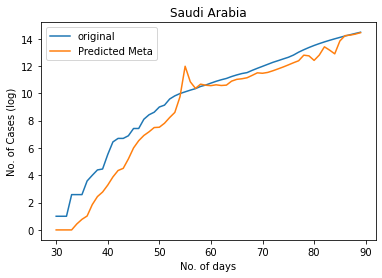

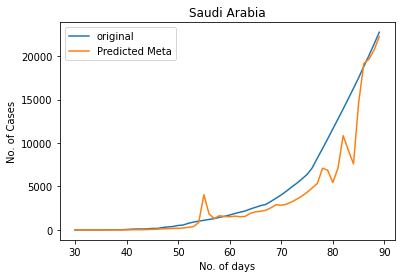

CID: 29
Error Meta:  1782.9381601215173


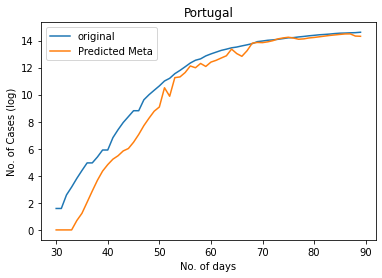

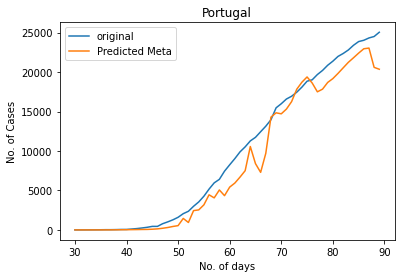

CID: 30
Error Meta:  1481.1741313339078


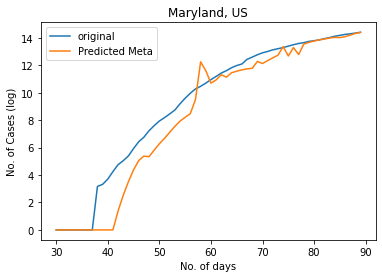

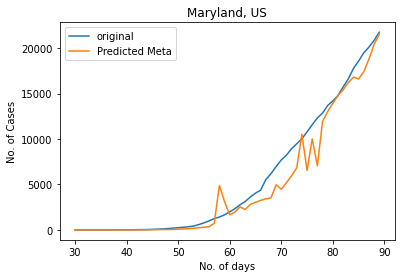

CID: 31
Error Meta:  1830.2225964011209


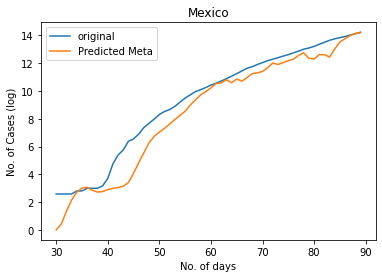

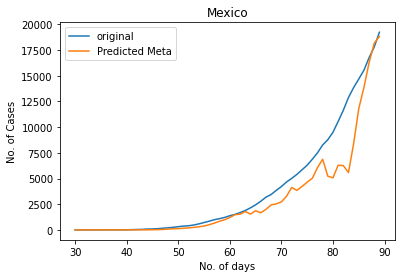

CID: 32
Error Meta:  1454.7955362953085


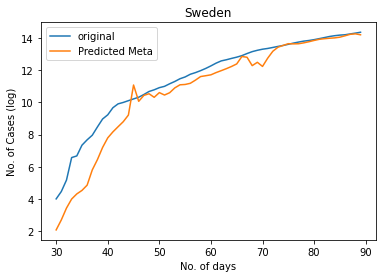

KeyboardInterrupt: ignored

In [0]:
#plotting nth day prediction
for i in range(0,56):
  print('CID:',i)
  x=np.empty(0)
  yM=np.empty(0)
  yT=np.empty(0)
  yO=np.empty(0)
  for j in range(30,90,1):
        x=np.append(x,j)
        yM=np.append(yM,mapp[i,j])
        # yT=np.append(yT,prediction_5th_day(data_country[i,j:j+7]))
        yO=np.append(yO,data_country[i,j+tedays+trdays])
  print('Error Meta: ',MSE(2**yO-1,2**yM-1)**0.5)
  plt.plot(x,yO,label='original')
  plt.plot(x,yM,label='Predicted Meta')
  # plt.plot(x,yT,label='Predicted Time Series')
  plt.legend()
  plt.title(country_names[i,0])
  plt.xlabel('No. of days')
  plt.ylabel('No. of Cases (log)')
  plt.show()
  plt.plot(x,2**yO-1,label='original')
  plt.plot(x,2**yM-1,label='Predicted Meta')
  # plt.plot(x,2**yT-1,label='Predicted Time Series')
  plt.legend()
  plt.title(country_names[i,0])
  plt.xlabel('No. of days')
  plt.ylabel('No. of Cases')
  plt.show()
  '''
  italy 2
  uk 3 
  germany 5
  turkey 6, upto 75
  russia 7 , upto 82
  peru 17,
  nether 18
  india 19
  texas 21
  switzerland 22, 80
  canada 23
  mexico 31
  sweden 32
  '''

CID: 0  CD: 48  -------------------Err: 0.034015029961077706


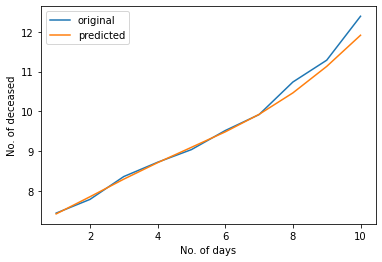

CID: 0  CD: 49  -------------------Err: 0.05058215816028753


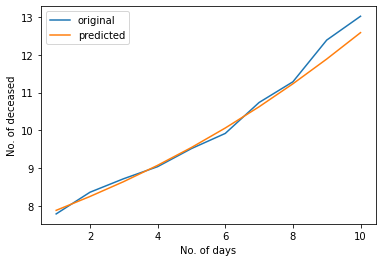

CID: 0  CD: 51  -------------------Err: 0.012351221336746798


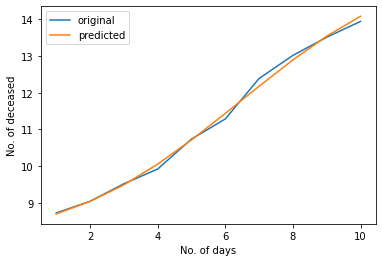

CID: 0  CD: 52  -------------------Err: 0.07462309986326607


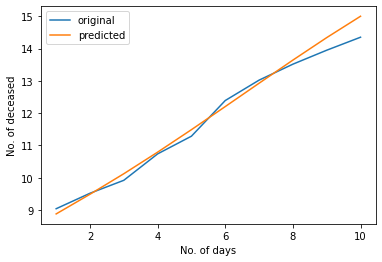

CID: 0  CD: 53  -------------------Err: 0.05430264434426937


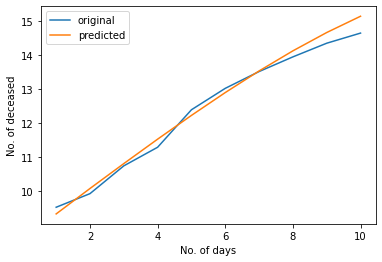

CID: 0  CD: 54  -------------------Err: 0.051946337058495586


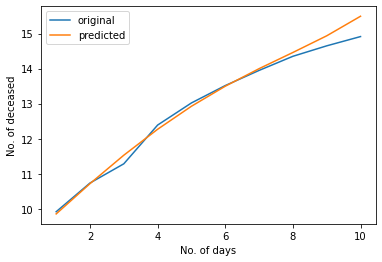

CID: 0  CD: 55  -------------------Err: 0.01624136502950891


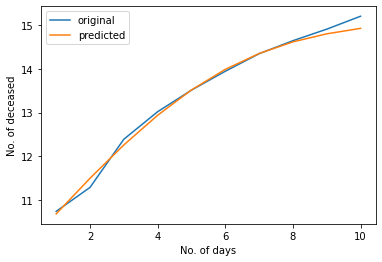

CID: 0  CD: 57  -------------------Err: 0.0034497182226627524


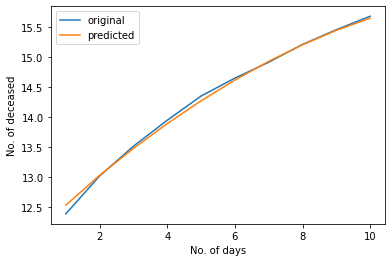

CID: 0  CD: 58  -------------------Err: 0.02761604270022827


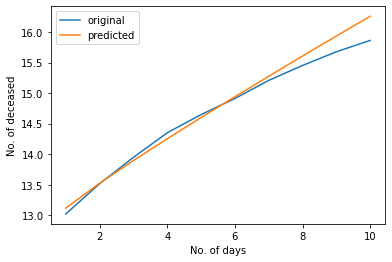

CID: 0  CD: 59  -------------------Err: 0.005351946567063307


KeyboardInterrupt: ignored

In [0]:
#not checked this block

#Set test data here
#country_id,country_day = 33,60
#print(PlotTest(0,80))
ec0,ec1,ec2,ec3=0,0,0,0
for i in range(0,1):
  for j in range(45,88,1):
       try:
        output= PlotTest(i,j)
        err= MSE(data_country[i,j:j+trdays+tedays],output)
        
        if(err<0.2 and err>0.0001):
          print('CID:',i,' CD:',j,' -------------------Err:',err)
          plt.plot(np.arange(1,trdays+tedays+1),data_country[i,j:j+trdays+tedays],label='original')
          plt.plot(np.arange(1,trdays+tedays+1),output,label='predicted')
          plt.legend()
          plt.xlabel('No. of days')
          plt.ylabel('No. of deceased')
          # if(output[13]>data_country[country_id,country_day:country_day+14][13]):
          #   plt.ylim(0,output[13]+1 )
          # else:
          #   plt.ylim(0,data_country[country_id,country_day:country_day+14][13]+1)
          plt.show()
        '''

        if(err==0):
          ec0+=1
        elif(err<0.1 ):
          ec1+=1
        elif(err<1 and err>=0.1):
          ec2+=1
        elif(err>=1):
          ec3+=1
        '''
       except Exception:
         pass
print(ec0,ec1,ec2,ec3)
#1288 486 2561 593 using 25 for 7
#1288 217 3020 403 using 2 for 5
#1288 180 3077 383 using 2 for 10